In [1]:
import numpy as np 
from math import sqrt
import pandas as pd
import time
import os

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision as tv

import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

## Датасет

In [2]:
class BCCDDataset(torch.utils.data.Dataset):
    def __init__(self, root='/kaggle/input/bccd-dataset/', trans=None):
        super()
        self.root = root
        self.pds = pd.read_csv(os.path.join(root,"test.csv"))
        self.clases = ['Bachground'] + list(self.pds.cell_type.unique())
        self.clases_idx = {w: i for i, w in enumerate(self.clases)}
        self.transforms = tv.transforms.Compose([
                tv.transforms.ToTensor(),
                tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ])
        self.imgs = self.pds.filename.unique()
        
    def get_image(self, idx):
        filename = self.imgs[idx]
        img = Image.open(os.path.join(self.root+'BCCD/JPEGImages',filename)).convert("RGB")
        return img
    
    def __getitem__(self, idx):
        filename = self.imgs[idx]
        img = Image.open(os.path.join(self.root+'BCCD/JPEGImages',filename)).convert("RGB")
        x = self.pds
        x = x[x.filename == filename]
        x = x[x.xmin < x.xmax]
        x = x[x.ymin < x.ymax]
        x = np.array(x)
        for i in range(len(x)):
            x[i,1]=self.clases_idx[x[i,1]]
        labels  = torch.as_tensor(x[:,1].astype(int), dtype=torch.int64).to(device)
        boxes = torch.as_tensor(x[:,[2,4,3,5]].astype(float), dtype=torch.float32).to(device)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(x),), dtype=torch.int64)


        img = self.transforms(img).to(device)

        return img, {'boxes':boxes, 'labels':labels}

    def __len__(self):
        return len(self.imgs)

In [5]:
dataset = BCCDDataset()
dataset[0]

(tensor([[[0.8961, 0.8961, 0.8961,  ..., 1.1358, 1.1015, 1.0673],
          [0.8961, 0.8961, 0.8961,  ..., 1.1358, 1.1015, 1.0673],
          [0.8961, 0.8961, 0.8961,  ..., 1.1358, 1.1015, 1.0673],
          ...,
          [1.4269, 1.3755, 1.3413,  ..., 0.6734, 0.7248, 0.8276],
          [1.4440, 1.3927, 1.3242,  ..., 0.6392, 0.6906, 0.7762],
          [1.4612, 1.4269, 1.3070,  ..., 0.6221, 0.6734, 0.7762]],
 
         [[0.6604, 0.6604, 0.6604,  ..., 1.4132, 1.3782, 1.3431],
          [0.6604, 0.6604, 0.6604,  ..., 1.4132, 1.3782, 1.3431],
          [0.6604, 0.6604, 0.6604,  ..., 1.4307, 1.3957, 1.3606],
          ...,
          [1.5532, 1.5182, 1.4307,  ..., 0.1176, 0.1527, 0.2577],
          [1.5707, 1.5182, 1.4132,  ..., 0.0826, 0.1176, 0.2052],
          [1.5882, 1.5007, 1.3957,  ..., 0.0651, 0.1001, 0.1702]],
 
         [[0.6879, 0.6879, 0.6879,  ..., 1.7337, 1.6988, 1.6640],
          [0.6879, 0.6879, 0.6879,  ..., 1.7337, 1.6988, 1.6640],
          [0.6531, 0.6531, 0.6879,  ...,

In [12]:
len(dataset)

364

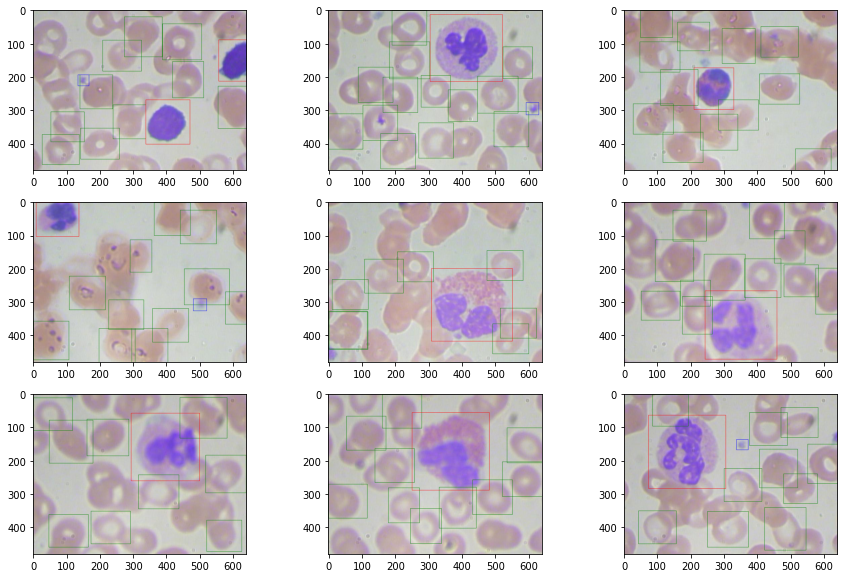

In [33]:
plt.figure(figsize= (15,10))
imgs = np.random.randint(len(dataset), size = 9)
i = 1
for n in imgs:
    plt.subplot(3, 3, i)
    img,box = dataset[n]
    image = dataset.get_image(n)
    draw = ImageDraw.Draw(image)
    classes = box['labels']
    boxes = box['boxes']
    i += 1
    for num,box in enumerate(boxes):
        c = classes[num]
        c = c if c < 4 else 0
        cl = ['black','red','green','blue']
        draw.rectangle(xy=box.tolist(), outline=cl[c])
    plt.imshow(image)  
    

## Модель

In [13]:
from torchvision.models.detection import ssd300_vgg16
model = ssd300_vgg16(pretrained = True).to(device)  

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


  0%|          | 0.00/136M [00:00<?, ?B/s]

In [14]:
model

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

## Обучение

In [16]:
# Отложим 5 случайных изображений для проверки качества модели
test = np.random.randint(len(dataset), size = 5)

In [26]:
model.train()
trainer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10
trn=list(set(range(len(dataset)))-set(test))
for ep in range(epochs):
    perm = np.random.permutation(trn)
    i = 0
    total_loss=0
    bbox_loss=0
    class_loss=0
    ln=0
    while True:
        pp=[]
        tt=[]
        trainer.zero_grad()
        for j in range(50):
            if i >= len(perm):
                break
            p,t = dataset[perm[i]]
            pp.append(p)
            tt.append(t)
            i +=1
        pred = model(pp,tt)
        loss = pred['bbox_regression'] * pred['bbox_regression'] * 20 + pred['classification']
        loss.backward()
        trainer.step()  
        bbox_loss+=pred['bbox_regression'].item()
        class_loss+=pred['classification'].item()
        total_loss+=loss.item()
        ln+=1
        if i >= len(perm):
            break
    print(f'{ep + 1} epoch: total_loss - {total_loss/ln:.3f}  bbox_loss - {bbox_loss/ln:.3f}  class_loss - {class_loss/ln:.3f}')

1 epoch: total_loss - 16.402  bbox_loss - 0.712  class_loss - 2.707
2 epoch: total_loss - 8.170  bbox_loss - 0.543  class_loss - 2.233
3 epoch: total_loss - 5.795  bbox_loss - 0.436  class_loss - 1.968
4 epoch: total_loss - 4.394  bbox_loss - 0.360  class_loss - 1.751
5 epoch: total_loss - 3.718  bbox_loss - 0.322  class_loss - 1.631
6 epoch: total_loss - 3.273  bbox_loss - 0.292  class_loss - 1.562
7 epoch: total_loss - 2.928  bbox_loss - 0.266  class_loss - 1.512
8 epoch: total_loss - 2.562  bbox_loss - 0.235  class_loss - 1.455
9 epoch: total_loss - 2.360  bbox_loss - 0.217  class_loss - 1.413
10 epoch: total_loss - 2.142  bbox_loss - 0.197  class_loss - 1.362


## Предсказания

In [23]:
img, _ = dataset[0]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [24]:
prediction

[{'boxes': tensor([[2.5855e+02, 1.7557e+02, 4.9151e+02, 3.7448e+02],
          [7.8014e+01, 3.2624e+02, 1.7759e+02, 4.3236e+02],
          [1.5712e+02, 7.6134e+01, 2.4311e+02, 1.7420e+02],
          [5.4013e+02, 3.3984e+01, 6.4000e+02, 1.3996e+02],
          [2.1049e+02, 3.5845e+02, 3.1583e+02, 4.5262e+02],
          [4.0472e+02, 3.5846e+02, 5.0968e+02, 4.5267e+02],
          [3.8583e+02, 1.1394e+01, 4.9483e+02, 1.1509e+02],
          [5.5368e+02, 3.5147e+02, 6.3960e+02, 4.5503e+02],
          [6.4053e+01, 2.2785e+02, 1.6216e+02, 3.3281e+02],
          [1.7118e+02, 1.8394e+02, 2.7129e+02, 2.8435e+02],
          [4.6638e+02, 4.0658e+02, 5.6581e+02, 4.8000e+02],
          [1.0435e+01, 8.6504e+01, 1.0560e+02, 1.6761e+02],
          [2.2484e+02, 8.9772e+01, 3.3628e+02, 1.7271e+02],
          [4.8795e+02, 1.2913e+02, 5.9333e+02, 2.3212e+02],
          [2.3512e+00, 3.3842e+02, 9.2792e+01, 4.3822e+02],
          [0.0000e+00, 3.7748e+02, 9.3867e+01, 4.7157e+02],
          [2.6605e+02, 2.4588e+

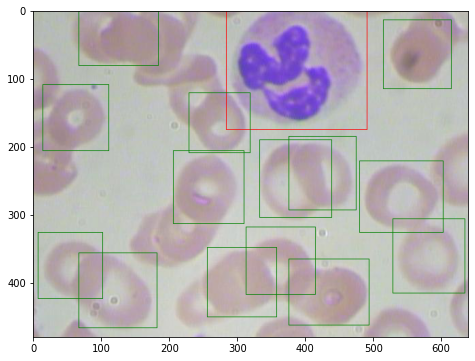

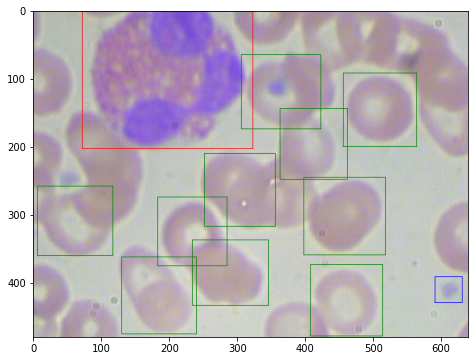

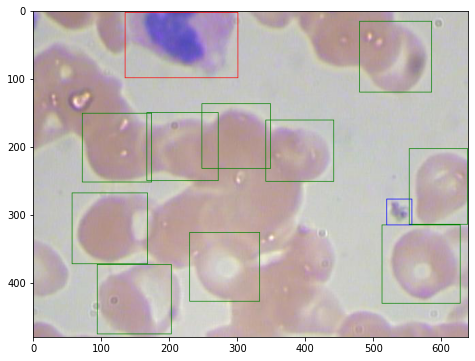

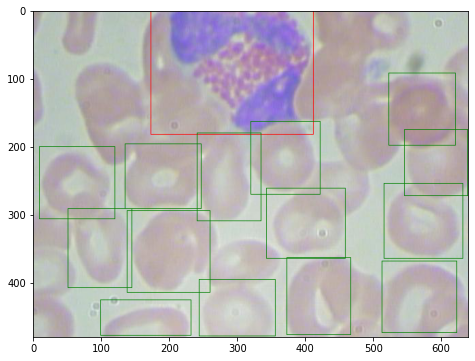

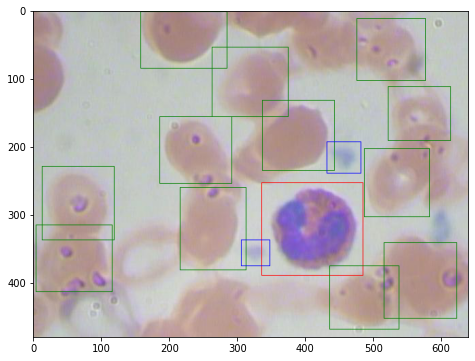

In [27]:
model.eval()
for i in test:
    img,_ = dataset[i]
    outputs = model([img])
    image = dataset.get_image(i)
    draw = ImageDraw.Draw(image)
    classes = outputs[0]['labels'].cpu().numpy()
    scores = outputs[0]['scores'].detach().cpu().numpy()
    boxes = outputs[0]['boxes'].detach().cpu().numpy()

    plt.figure(figsize=(8,6))
    for i,box in enumerate(boxes):
        if scores[i] > 0.5 :
            c = classes[i]
            c = c if c < 4 else 0
            cl = ['black','red','green','blue']
            draw.rectangle(xy=box.tolist(), outline=cl[c])
    plt.imshow(image)